<a href="https://colab.research.google.com/github/6enius/ICON-GOLD-Mission-Storm-Analysis/blob/main/ICON_%2B_GOLD_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is guildence of how to create ICON and GOLD

###Extentions
import necessary extentions

In [ ]:
!pip install cartopy
!pip install cftime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.9 MB/s eta 0:00:00


In [ ]:
from google.colab import files
from google.colab import drive
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.dates import DateFormatter, MinuteLocator
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import bisect
import seaborn as sns
import pylab
import os
import glob
from ftplib import FTP
import fnmatch
import matplotlib.dates as mdates
import xarray as xr
import cftime
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import imageio.v2 as imageio

###Files
Locate files in google drive, open files to check

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
combined_gold_icon_nov2021 = '/content/drive/MyDrive/ColabNotebooks/DATA/combined_gold_icon_nov2021.nc' # you will have to change this file location to your file locaiton
gold_and_icon = xr.open_dataset(combined_gold_icon_nov2021)

In [ ]:
gold_and_icon
#this code opens the file to check the identity of each variable

<xarray.Dataset> Size: 5MB
Dimensions:           (LAT: 37, LON: 43, UT: 34, DoY: 9, Year: 1, LONICON: 19777)
Coordinates:
  * LONICON           (LONICON) float32 79kB 37.19 41.38 45.66 ... 171.1 172.8
Dimensions without coordinates: LAT, LON, UT, DoY, Year
Data variables: (12/15)
    LATGOLD           (LAT) float32 148B ...
    LONGOLD           (LON) float32 172B ...
    UTGOLD            (UT) float32 136B ...
    DoYGOLD           (DoY) float32 36B ...
    YEARGOLD          (Year) float32 4B ...
    on2GOLD           (DoY, UT, LAT, LON) float32 2MB ...
    ...                ...
    uwndicon          (LONICON) float32 79kB ...
    vwndicon          (LONICON) float32 79kB ...
    uwndmeanicon      (LONICON) float32 79kB ...
    vwndmeanicon      (LONICON) float32 79kB ...
    uwndresiduesicon  (LONICON) float32 79kB ...
    vwndresiduesicon  (LONICON) float32 79kB ...

###Shortcuts
This section defines serval shourcuts variable of later code.

In [ ]:
data_vars = {
    'LATGOLD': gold_and_icon['LATGOLD'],
    'LONGOLD': gold_and_icon['LONGOLD'],
    'UTGOLD': gold_and_icon['UTGOLD'],
    'DoYGOLD': gold_and_icon['DoYGOLD'],
    'YEARGOLD': gold_and_icon['YEARGOLD'],
    'on2GOLD': gold_and_icon['on2GOLD'],
    'tdiskGOLD': gold_and_icon['tdiskGOLD'],
    'LATICON': gold_and_icon['LATICON'],
    'DoYICON': gold_and_icon['DoYICON'],
    'uwndicon': gold_and_icon['uwndicon'],
    'vwndicon': gold_and_icon['vwndicon'],
    'uwndmeanicon': gold_and_icon['uwndmeanicon'],
    'vwndmeanicon': gold_and_icon['vwndmeanicon'],
    'uwndresiduesicon': gold_and_icon['uwndresiduesicon'],
    'vwndresiduesicon': gold_and_icon['vwndresiduesicon']
}

In [ ]:
lat_gold_values = gold_and_icon['LATGOLD'].values
long_gold_values = gold_and_icon['LONGOLD'].values
lat_max = lat_gold_values.max()
lat_min = lat_gold_values.min()
lon_max = long_gold_values.max()
lon_min = long_gold_values.min()

In [ ]:
ut_gold = gold_and_icon['UTGOLD']
ut_index = np.where(ut_gold == 14.5)[0][0]
doy_gold = gold_and_icon['DoYGOLD']
doy_index = np.where(doy_gold == 308)[0][0]
on2_gold = data_vars['on2GOLD']

In [ ]:
lons = gold_and_icon['LONICON'].values
lats = gold_and_icon['LATICON'].values
uwndicon = data_vars['uwndicon'].values
vwndicon = data_vars['vwndicon'].values
uwndmeanicon = data_vars['uwndmeanicon'].values
vwndmeanicon = data_vars['vwndmeanicon'].values
uwndresiduesicon = data_vars['uwndresiduesicon'].values
vwndresiduesicon = data_vars['vwndresiduesicon'].values
doyICON = gold_and_icon['DoYICON'].values

##Step 1: Creating a clean Canva

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


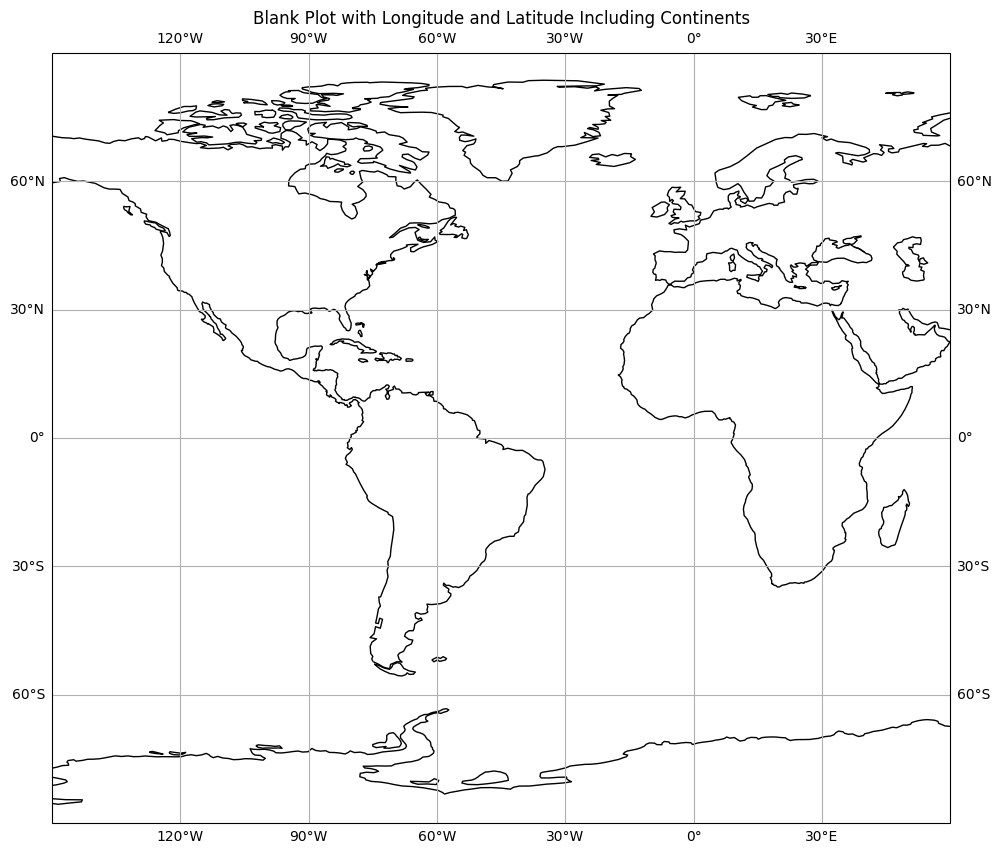

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Blank Plot with Longitude and Latitude Including Continents')
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
ax.add_feature(cfeature.COASTLINE)
ax.gridlines(draw_labels=True)
plt.show()

##Step 2: GOLD data
- graph 1: GOLD O/n2 graph
- graph 2: GOLD Tdisk graph

this data contains the file on2GOLD
on2GOLD is a 4D array contains [DoYGOLD, UTGOLD, LATGOLD, LONGOLD]
dataset will be too small if DoYGOLD and UTGOLD are both fixed
thus, i looped all data in the same UTGOLD then start a new loop by change UTGOLD
however, if DoYGOLD is not fixed, it will ruind the data.
for conclude, LATGOLD and LONGOLD are data that are looped under the big loop of UTGOLD
all these code are run under DoYGOLD == 308

<ipython-input-11-3b83a00abc4c>:38: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh, ax=ax, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7))


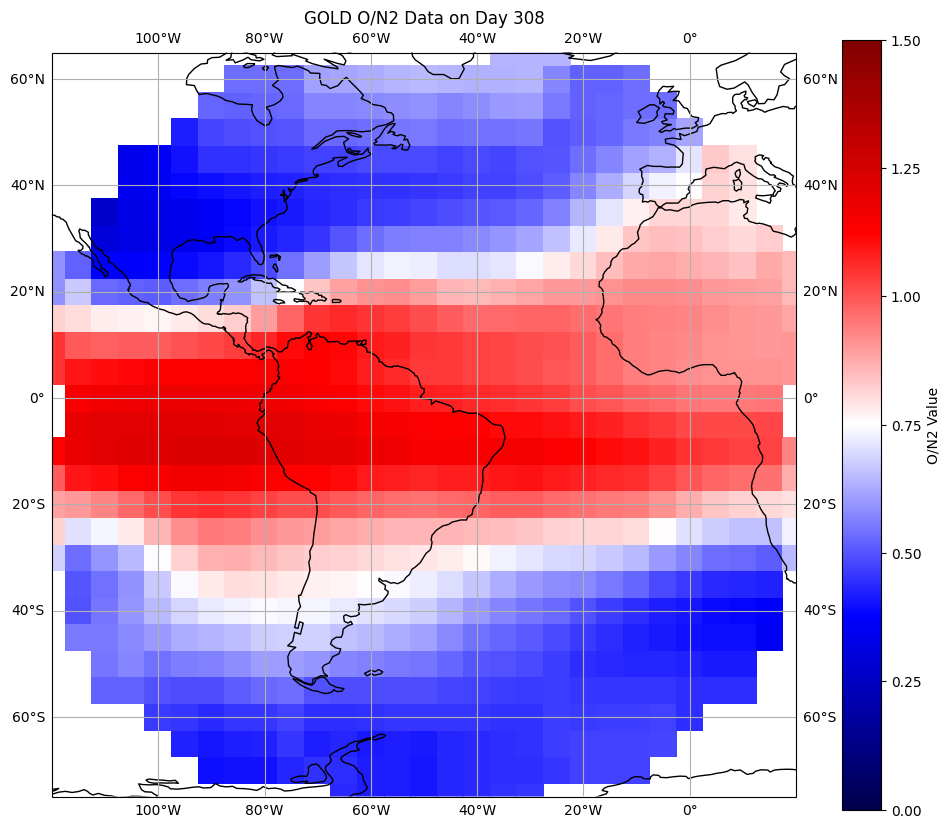

In [ ]:
#GOLD O/N2

lat_min_valid = float('inf')
lat_max_valid = float('-inf')
lon_min_valid = float('inf')
lon_max_valid = float('-inf')
lat_len = len(gold_and_icon['LATGOLD'].values)
lon_len = len(gold_and_icon['LONGOLD'].values)
min_len = min(lat_len, lon_len)
on2_gold = data_vars['on2GOLD']

for i in range(lat_len):
    for j in range(lon_len):
        on2 = on2_gold[doy_index, ut_index, i, j].values.item()
        if not np.isnan(on2):
            lat_min_valid = min(lat_min_valid, gold_and_icon['LATGOLD'].values[i])
            lat_max_valid = max(lat_max_valid, gold_and_icon['LATGOLD'].values[i])
            lon_min_valid = min(lon_min_valid, gold_and_icon['LONGOLD'].values[j])
            lon_max_valid = max(lon_max_valid, gold_and_icon['LONGOLD'].values[j])

fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('GOLD O/N2 Data on Day 308')
ax.set_xlim(lon_min_valid, lon_max_valid)
ax.set_ylim(lat_min_valid, lat_max_valid)
ax.add_feature(cfeature.COASTLINE)

valid_on2_grid = np.full((lat_len, lon_len), np.nan)

for i in range(lat_len):
    for j in range(lon_len):
        on2 = on2_gold[doy_index, ut_index, i, j].values.item()
        if on2 != 0 and not np.isnan(on2):
            valid_on2_grid[i, j] = on2

mesh = ax.pcolor(gold_and_icon['LONGOLD'].values, gold_and_icon['LATGOLD'].values, valid_on2_grid, cmap='seismic', shading='auto', vmin=0, vmax=1.5)
fig.colorbar(mesh, ax=ax, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7))
ax.gridlines(draw_labels=True)
plt.show()

<ipython-input-12-39a7c8616c2b>:49: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh, ax=ax, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7))


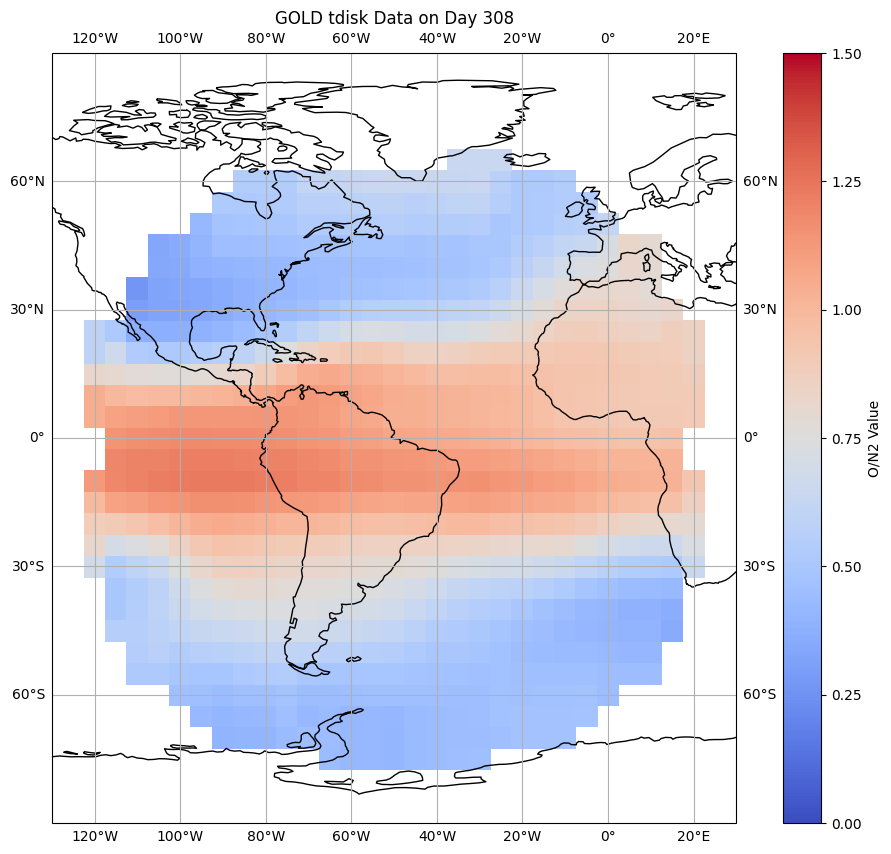

In [ ]:
lat_min_valid = float('inf')
lat_max_valid = float('-inf')
lon_min_valid = float('inf')
lon_max_valid = float('-inf')

tdisk_gold = data_vars['tdiskGOLD']

for i in range(lat_len):
    for j in range(lon_len):
        tdisk = tdisk_gold[doy_index, ut_index, i, j].values.item()

        if not np.isnan(tdisk):
            lat_min_valid = min(lat_min_valid, gold_and_icon['LATGOLD'].values[i])
            lat_max_valid = max(lat_max_valid, gold_and_icon['LATGOLD'].values[i])
            lon_min_valid = min(lon_min_valid, gold_and_icon['LONGOLD'].values[j])
            lon_max_valid = max(lon_max_valid, gold_and_icon['LONGOLD'].values[j])

lat_len = len(gold_and_icon['LATGOLD'].values)
lon_len = len(gold_and_icon['LONGOLD'].values)
min_len = min(lat_len, lon_len)
tdisk_gold = data_vars['tdiskGOLD']

for i in range(lat_len):
    for j in range(lon_len):
        tdisk = tdisk_gold[doy_index, ut_index, i, j].values.item()
        if not np.isnan(on2):
            lat_min_valid = min(lat_min_valid, gold_and_icon['LATGOLD'].values[i])
            lat_max_valid = max(lat_max_valid, gold_and_icon['LATGOLD'].values[i])
            lon_min_valid = min(lon_min_valid, gold_and_icon['LONGOLD'].values[j])
            lon_max_valid = max(lon_max_valid, gold_and_icon['LONGOLD'].values[j])

fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('GOLD tdisk Data on Day 308')
ax.set_xlim(-130, 30)
ax.set_ylim(-90, 90)
ax.add_feature(cfeature.COASTLINE)

valid_on2_grid = np.full((lat_len, lon_len), np.nan)

for i in range(lat_len):
    for j in range(lon_len):
        on2 = on2_gold[doy_index, ut_index, i, j].values.item()
        if on2 != 0 and not np.isnan(on2):
            valid_on2_grid[i, j] = on2

mesh = ax.pcolor(gold_and_icon['LONGOLD'].values, gold_and_icon['LATGOLD'].values, valid_on2_grid, cmap='coolwarm', shading='auto', vmin=0, vmax=1.5)
fig.colorbar(mesh, ax=ax, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7))
ax.gridlines(draw_labels=True)
plt.show()

##Step 3: ICON data
- graph 3: ICON wind vectors

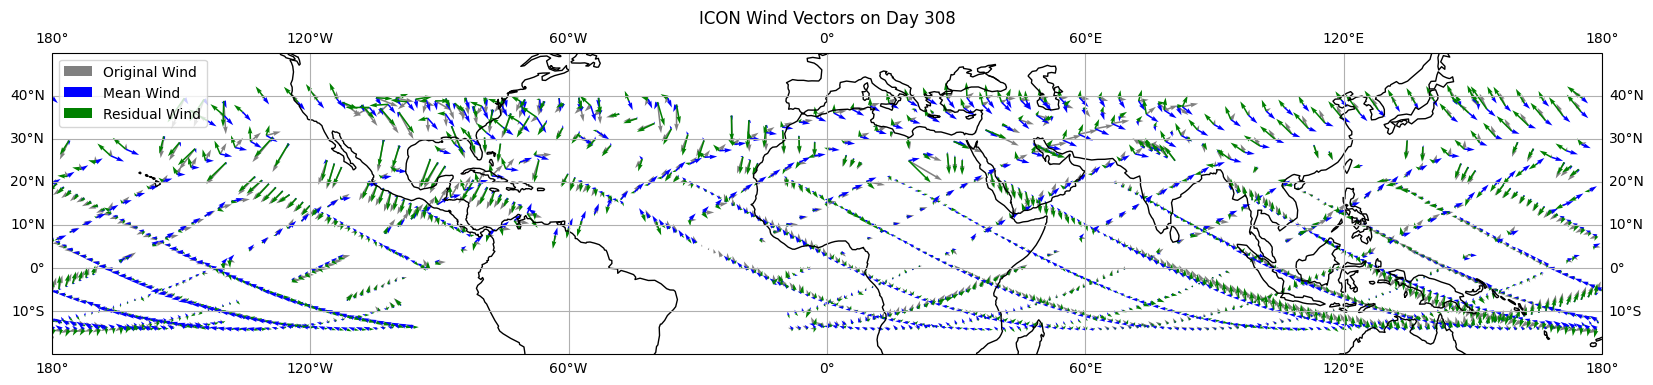

In [ ]:
condition = (doyICON >= 308) & (doyICON < 309)
filtered_indices = np.where(condition)[0]

lons_filtered = lons[filtered_indices]
lats_filtered = lats[filtered_indices]
uwndicon_filtered = uwndicon[filtered_indices]
vwndicon_filtered = vwndicon[filtered_indices]
uwndmeanicon_filtered = uwndmeanicon[filtered_indices]
vwndmeanicon_filtered = vwndmeanicon[filtered_indices]
uwndresiduesicon_filtered = uwndresiduesicon[filtered_indices]
vwndresiduesicon_filtered = vwndresiduesicon[filtered_indices]

lat_min, lat_max = -20, 50
lon_min, lon_max = -180, 180
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('ICON Wind Vectors on Day 308')
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
ax.add_feature(cfeature.COASTLINE)
ax.gridlines(draw_labels=True)

ax.quiver(lons_filtered, lats_filtered, uwndicon_filtered, vwndicon_filtered, color='gray', scale=15000, width=0.001, label='Original Wind')
ax.quiver(lons_filtered, lats_filtered, uwndmeanicon_filtered, vwndmeanicon_filtered, color='blue', scale=15000, width=0.001, label='Mean Wind')
ax.quiver(lons_filtered, lats_filtered, uwndresiduesicon_filtered, vwndresiduesicon_filtered, color='green', scale=15000, width=0.001, label='Residual Wind')

plt.legend(loc='upper left')

plt.show()

##Step 4: ICON + GOLD data combination
Hint: ICON data have to be sorted out. only data from that specific UT time should be include in the graph.

#####GOLD O/n2 Data + ICON Wind Vector Data
Copy the Gold Data graph from step 2 - graph 1, and add on ICON wind vector data.

<ipython-input-14-9d900f6da521>:45: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh, ax=ax, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7))


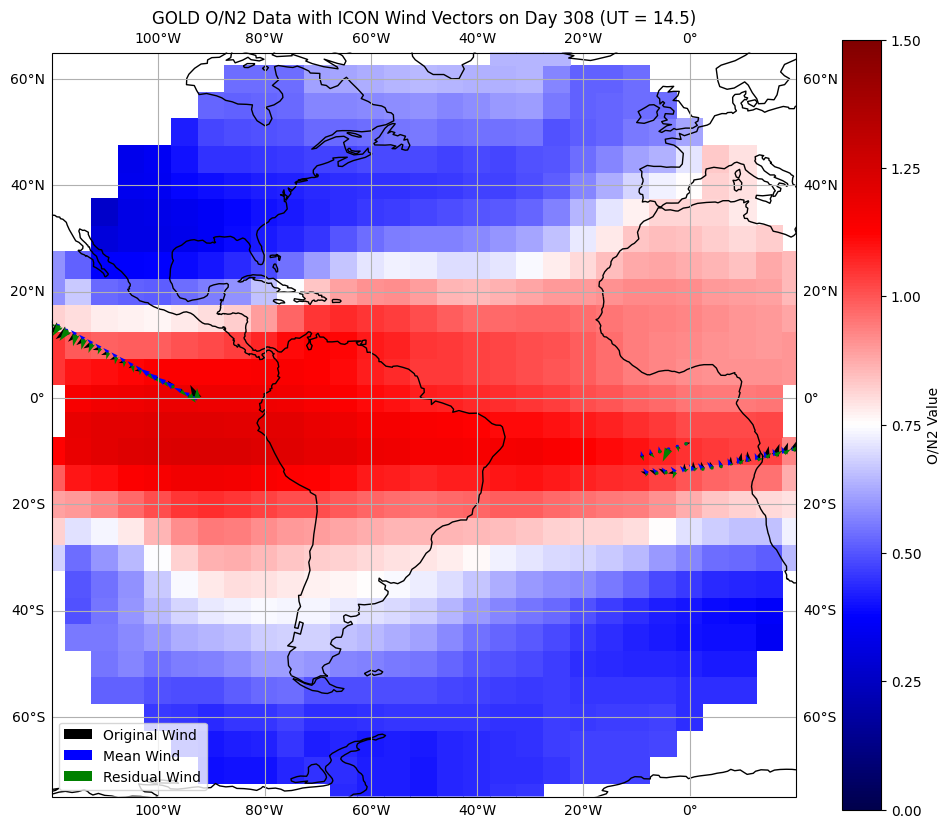

In [ ]:
UT_time = 14.5
ut_index = np.where(gold_and_icon['UTGOLD'].values == UT_time)[0][0]

lat_min_valid = float('inf')
lat_max_valid = float('-inf')
lon_min_valid = float('inf')
lon_max_valid = float('-inf')
lat_len = len(gold_and_icon['LATGOLD'].values)
lon_len = len(gold_and_icon['LONGOLD'].values)
on2_gold = data_vars['on2GOLD']

for i in range(lat_len):
    for j in range(lon_len):
        on2 = on2_gold[doy_index, ut_index, i, j].values.item()
        if not np.isnan(on2):
            lat_min_valid = min(lat_min_valid, gold_and_icon['LATGOLD'].values[i])
            lat_max_valid = max(lat_max_valid, gold_and_icon['LATGOLD'].values[i])
            lon_min_valid = min(lon_min_valid, gold_and_icon['LONGOLD'].values[j])
            lon_max_valid = max(lon_max_valid, gold_and_icon['LONGOLD'].values[j])

fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('GOLD O/N2 Data with ICON Wind Vectors on Day 308 (UT = 14.5)')
ax.set_xlim(lon_min_valid, lon_max_valid)
ax.set_ylim(lat_min_valid, lat_max_valid)
ax.add_feature(cfeature.COASTLINE)

valid_on2_grid = np.full((lat_len, lon_len), np.nan)
for i in range(lat_len):
    for j in range(lon_len):
        on2 = on2_gold[doy_index, ut_index, i, j].values.item()
        if on2 != 0 and not np.isnan(on2):
            valid_on2_grid[i, j] = on2

mesh = ax.pcolor(
    gold_and_icon['LONGOLD'].values,
    gold_and_icon['LATGOLD'].values,
    valid_on2_grid,
    cmap='seismic',
    shading='auto',
    vmin=0,
    vmax=1.5
)
fig.colorbar(mesh, ax=ax, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7))

condition = (doyICON >= 308.5833) & (doyICON < 308.6667)
filtered_indices = np.where(condition)[0]

lons_filtered = lons[filtered_indices]
lats_filtered = lats[filtered_indices]
uwndicon_filtered = uwndicon[filtered_indices]
vwndicon_filtered = vwndicon[filtered_indices]
uwndmeanicon_filtered = uwndmeanicon[filtered_indices]
vwndmeanicon_filtered = vwndmeanicon[filtered_indices]
uwndresiduesicon_filtered = uwndresiduesicon[filtered_indices]
vwndresiduesicon_filtered = vwndresiduesicon[filtered_indices]

#can change the scale of ICON vector here
ax.quiver( lons_filtered, lats_filtered, uwndicon_filtered, vwndicon_filtered,
    color='black', scale=5000, width=0.005, label='Original Wind')
ax.quiver( lons_filtered, lats_filtered, uwndmeanicon_filtered, vwndmeanicon_filtered,
    color='blue', scale=5000, width=0.005, label='Mean Wind')
ax.quiver( lons_filtered, lats_filtered, uwndresiduesicon_filtered, vwndresiduesicon_filtered,
    color='green',  scale=5000,  width=0.005,  label='Residual Wind')

ax.legend(loc='lower left')
ax.gridlines(draw_labels=True)

plt.show()

####GOLD Tdisk Data + ICON Wind Vector Data
Copy the Gold Data graph from step 2 - graph 2, and add on ICON wind vector data.

<ipython-input-15-898e05586fa8>:30: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh, ax=ax, label='Tdisk Value')


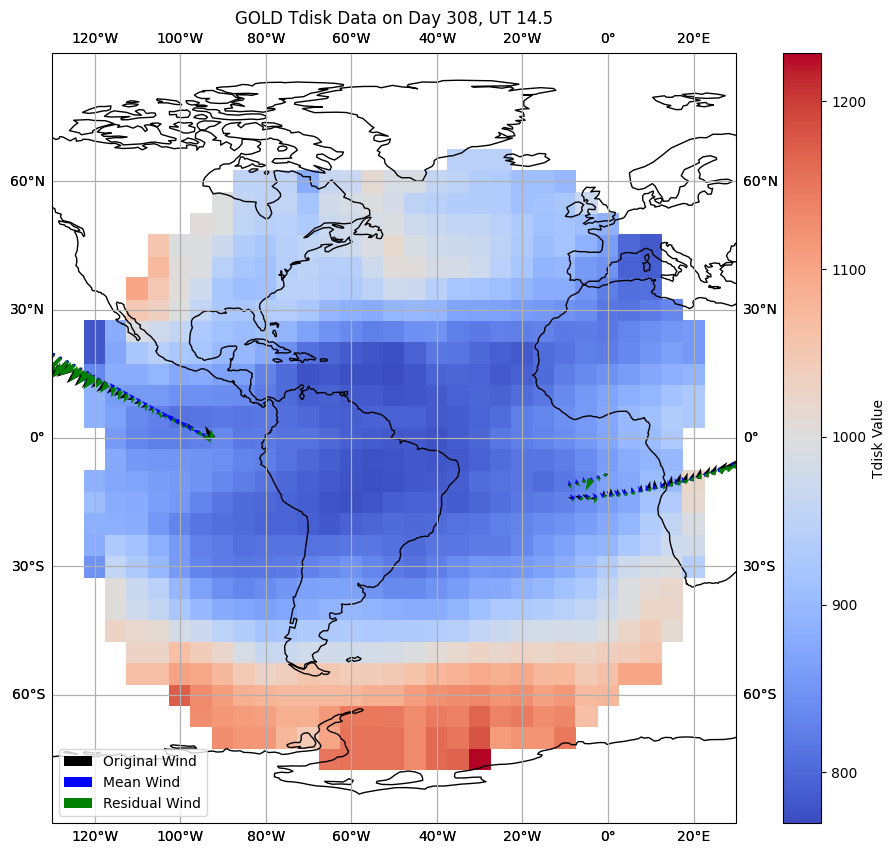

In [ ]:
UT_time = 14.5
ut_index = np.where(gold_and_icon['UTGOLD'].values == UT_time)[0][0]

lat_len = len(gold_and_icon['LATGOLD'].values)
lon_len = len(gold_and_icon['LONGOLD'].values)
tdisk_gold = data_vars['tdiskGOLD']

fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('GOLD Tdisk Data on Day 308, UT 14.5')
ax.set_xlim(-130, 30)
ax.set_ylim(-90, 90)
ax.add_feature(cfeature.COASTLINE)

valid_tdisk_grid = np.full((lat_len, lon_len), np.nan)
for i in range(lat_len):
    for j in range(lon_len):
        tdisk = tdisk_gold[doy_index, ut_index, i, j].values.item()
        if not np.isnan(tdisk):
            valid_tdisk_grid[i, j] = tdisk

mesh = ax.pcolor(
    gold_and_icon['LONGOLD'].values,
    gold_and_icon['LATGOLD'].values,
    valid_tdisk_grid,
    cmap='coolwarm',
    shading='auto'
)
fig.colorbar(mesh, ax=ax, label='Tdisk Value')
ax.gridlines(draw_labels=True)

condition = (doyICON >= 308.5833) & (doyICON <= 308.6667)
filtered_indices = np.where(condition)[0]

lons_filtered = lons[filtered_indices]
lats_filtered = lats[filtered_indices]
uwndicon_filtered = uwndicon[filtered_indices]
vwndicon_filtered = vwndicon[filtered_indices]
uwndmeanicon_filtered = uwndmeanicon[filtered_indices]
vwndmeanicon_filtered = vwndmeanicon[filtered_indices]
uwndresiduesicon_filtered = uwndresiduesicon[filtered_indices]
vwndresiduesicon_filtered = vwndresiduesicon[filtered_indices]

ax.quiver( lons_filtered, lats_filtered, uwndicon_filtered, vwndicon_filtered,
    color='black', scale=5000, width=0.005, label='Original Wind')
ax.quiver( lons_filtered, lats_filtered, uwndmeanicon_filtered, vwndmeanicon_filtered,
    color='blue', scale=5000, width=0.005, label='Mean Wind')
ax.quiver( lons_filtered, lats_filtered, uwndresiduesicon_filtered, vwndresiduesicon_filtered,
    color='green',  scale=5000,  width=0.005,  label='Residual Wind')

ax.legend(loc='lower left')
ax.gridlines(draw_labels=True)
plt.show()

##Step 5: Combination of all graphs
Putting all three graphs (GOLD O/n2, GOLD Tdisk, ICON Wind Vector) on the same canva

<ipython-input-16-a60dacc3e606>:30: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)
<ipython-input-16-a60dacc3e606>:84: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh2, ax=ax2, label='Tdisk Value', shrink=0.7)


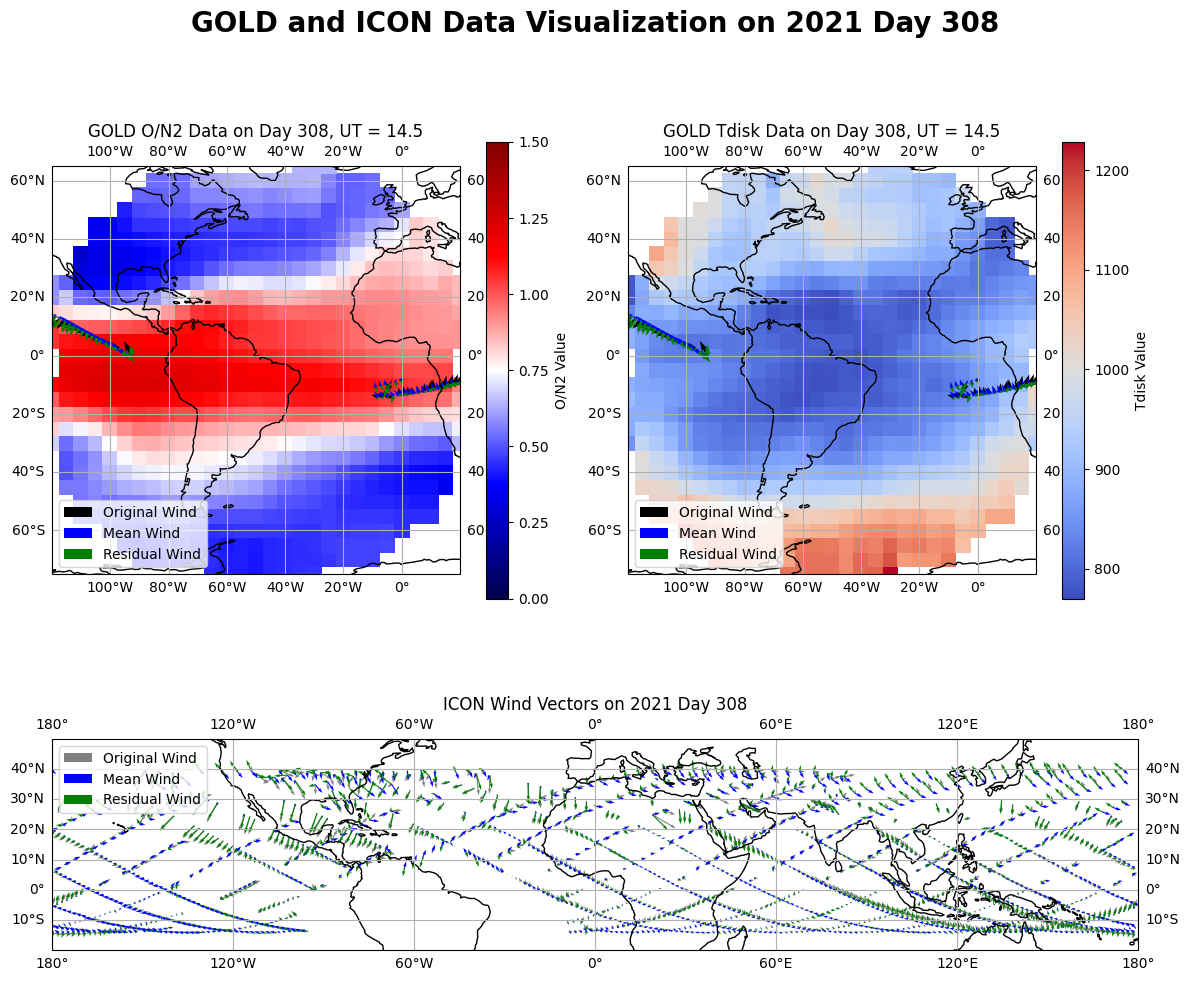

In [ ]:
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2, height_ratios=[2, 2])
fig.suptitle("GOLD and ICON Data Visualization on 2021 Day 308", fontsize=20, weight='bold')

# ------------------ GOLD O/N2 (Graph 1) ------------------
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('GOLD O/N2 Data on Day 308, UT = 14.5')
ax1.set_xlim(lon_min_valid, lon_max_valid)
ax1.set_ylim(lat_min_valid, lat_max_valid)
ax1.add_feature(cfeature.COASTLINE)

valid_on2_grid = np.full((lat_len, lon_len), np.nan)
for i in range(lat_len):
    for j in range(lon_len):
        on2 = on2_gold[doy_index, ut_index, i, j].values.item()
        if on2 != 0 and not np.isnan(on2):
            valid_on2_grid[i, j] = on2

mesh1 = ax1.pcolor(
    gold_and_icon['LONGOLD'].values,
    gold_and_icon['LATGOLD'].values,
    valid_on2_grid,
    cmap='seismic',
    shading='auto',
    vmin=0,
    vmax=1.5
)
fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)

condition = (doyICON >= 308.5833) & (doyICON <= 308.6667)
filtered_indices = np.where(condition)[0]
lons_filtered = lons[filtered_indices]
lats_filtered = lats[filtered_indices]
uwndicon_filtered = uwndicon[filtered_indices]
vwndicon_filtered = vwndicon[filtered_indices]
uwndmeanicon_filtered = uwndmeanicon[filtered_indices]
vwndmeanicon_filtered = vwndmeanicon[filtered_indices]
uwndresiduesicon_filtered = uwndresiduesicon[filtered_indices]
vwndresiduesicon_filtered = vwndresiduesicon[filtered_indices]

ax1.quiver(
    lons_filtered, lats_filtered,
    uwndicon_filtered, vwndicon_filtered,
    color='black', scale=2500, width=0.005, label='Original Wind'
)
ax1.quiver(
    lons_filtered, lats_filtered,
    uwndmeanicon_filtered, vwndmeanicon_filtered,
    color='blue', scale=2500, width=0.005, label='Mean Wind'
)
ax1.quiver(
    lons_filtered, lats_filtered,
    uwndresiduesicon_filtered, vwndresiduesicon_filtered,
    color='green', scale=2500, width=0.005, label='Residual Wind'
)
ax1.legend(loc='lower left')
ax1.gridlines(draw_labels=True)

# ------------------ GOLD TDisk (Graph 2) ------------------
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('GOLD Tdisk Data on Day 308, UT = 14.5')
ax2.set_xlim(lon_min_valid, lon_max_valid)
ax2.set_ylim(lat_min_valid, lat_max_valid)
ax2.add_feature(cfeature.COASTLINE)

valid_tdisk_grid = np.full((lat_len, lon_len), np.nan)
for i in range(lat_len):
    for j in range(lon_len):
        tdisk = tdisk_gold[doy_index, ut_index, i, j].values.item()
        if not np.isnan(tdisk):
            valid_tdisk_grid[i, j] = tdisk

mesh2 = ax2.pcolor(
    gold_and_icon['LONGOLD'].values,
    gold_and_icon['LATGOLD'].values,
    valid_tdisk_grid,
    cmap='coolwarm',
    shading='auto'
)
fig.colorbar(mesh2, ax=ax2, label='Tdisk Value', shrink=0.7)

ax2.quiver(
    lons_filtered, lats_filtered,
    uwndicon_filtered, vwndicon_filtered,
    color='black', scale=2500, width=0.005, label='Original Wind'
)
ax2.quiver(
    lons_filtered, lats_filtered,
    uwndmeanicon_filtered, vwndmeanicon_filtered,
    color='blue', scale=2500, width=0.005, label='Mean Wind'
)
ax2.quiver(
    lons_filtered, lats_filtered,
    uwndresiduesicon_filtered, vwndresiduesicon_filtered,
    color='green', scale=2500, width=0.005, label='Residual Wind'
)
ax2.legend(loc='lower left')
ax2.gridlines(draw_labels=True)

# ------------------ ICON Wind Vectors (Full Map) ------------------
ax3 = fig.add_subplot(gs[1, :], projection=ccrs.PlateCarree())
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.set_title('ICON Wind Vectors on 2021 Day 308')
ax3.set_xlim(-180, 180)
ax3.set_ylim(-20, 50)
ax3.add_feature(cfeature.COASTLINE)
ax3.gridlines(draw_labels=True)

condition = (doyICON >= 308) & (doyICON < 309)
filtered_indices2 = np.where(condition)[0]

lons_filtered = lons[filtered_indices2]
lats_filtered = lats[filtered_indices2]
uwndicon_filtered = uwndicon[filtered_indices2]
vwndicon_filtered = vwndicon[filtered_indices2]
uwndmeanicon_filtered = uwndmeanicon[filtered_indices2]
vwndmeanicon_filtered = vwndmeanicon[filtered_indices2]
uwndresiduesicon_filtered = uwndresiduesicon[filtered_indices2]
vwndresiduesicon_filtered = vwndresiduesicon[filtered_indices2]

ax3.quiver(lons_filtered, lats_filtered, uwndicon_filtered, vwndicon_filtered, color='gray', scale=15000, width=0.001, label='Original Wind')
ax3.quiver(lons_filtered, lats_filtered, uwndmeanicon_filtered, vwndmeanicon_filtered, color='blue', scale=15000, width=0.001, label='Mean Wind')
ax3.quiver(lons_filtered, lats_filtered, uwndresiduesicon_filtered, vwndresiduesicon_filtered, color='green', scale=15000, width=0.001, label='Residual Wind')
ax3.legend(loc='upper left')

# ------------------ Output ------------------
plt.subplots_adjust(hspace=0.0001, wspace=0.00001, top=1)  # Add space between plots
plt.tight_layout()
plt.show()

##Step 6: Processing all data from a specific date
In this example, I will process all data graph from day 308 and add them to my google drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(6.5, dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(7., dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(7.5, dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(8., dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(8.5, dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(9., dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(9.5, dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(10., dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(10.5, dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(11., dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(11.5, dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(12., dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(12.5, dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(13., dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(13.5, dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])
Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(14., dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)
<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(14.5, dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(15., dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(15.5, dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)
<ipython-input-17-67106795801d>:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12, 12))


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(16., dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(16.5, dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(17., dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(17.5, dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(18., dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(18.5, dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(19., dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(19.5, dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(20., dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(20.5, dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(21., dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(21.5, dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(22., dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(22.5, dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


<ipython-input-17-67106795801d>:58: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)


Error encountered at UT value <xarray.DataArray 'UTGOLD' ()> Size: 4B
array(23., dtype=float32)
Attributes:
    units:      hr
    long_name:  Universal Time: applied function returned data with an unexpected number of dimensions. Received 1 dimension(s) but expected 0 dimensions with names (), from:

array([False, False, False, ...,  True,  True,  True])


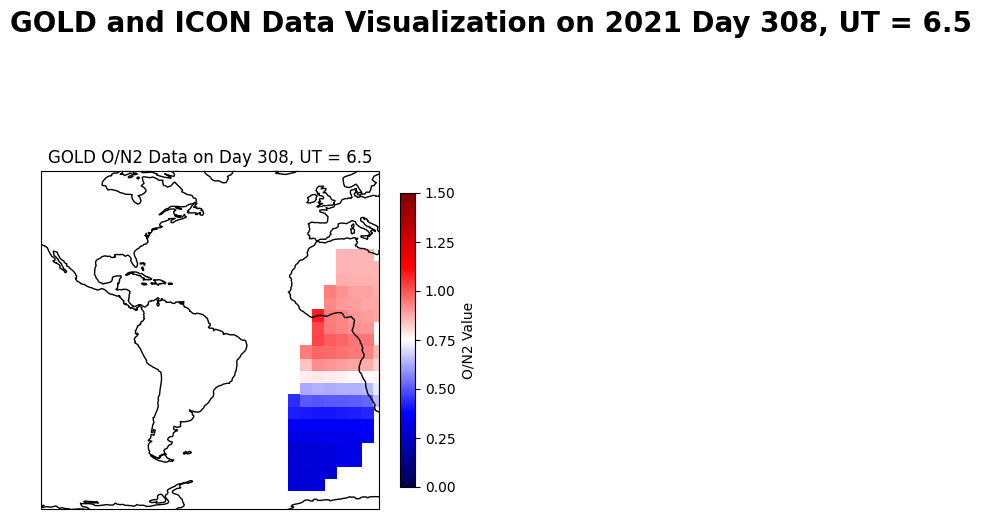

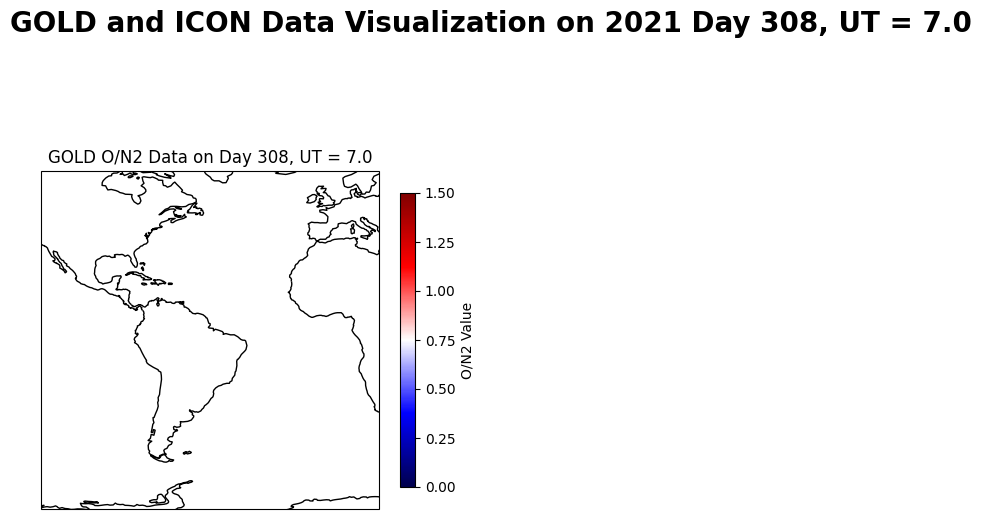

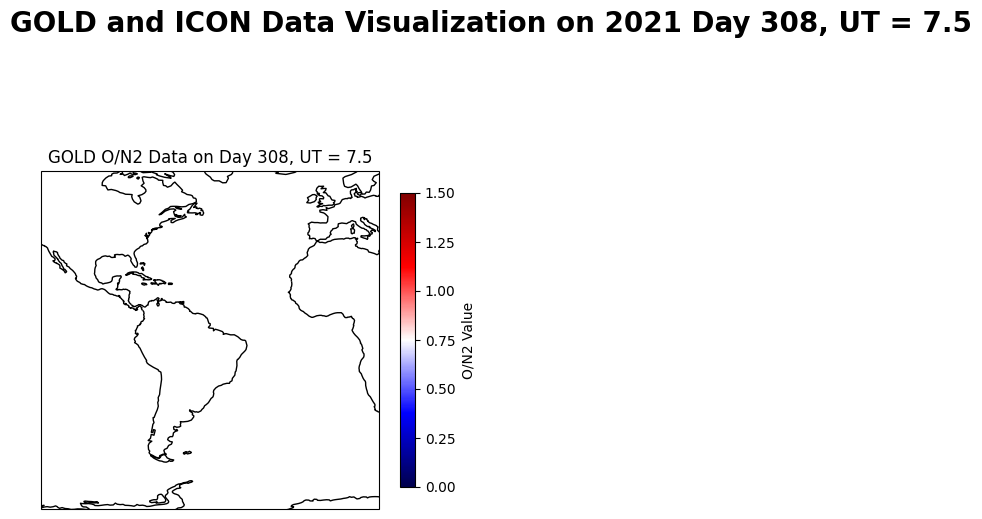

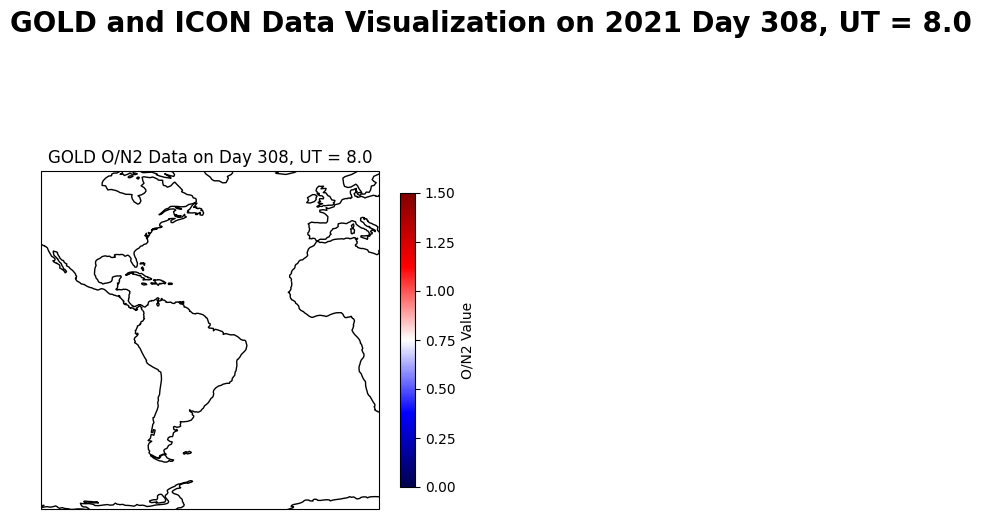

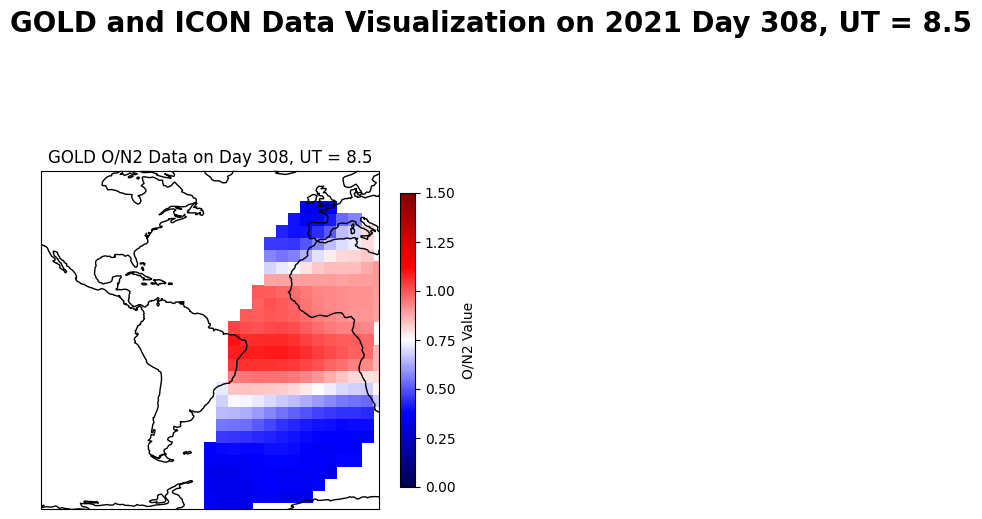

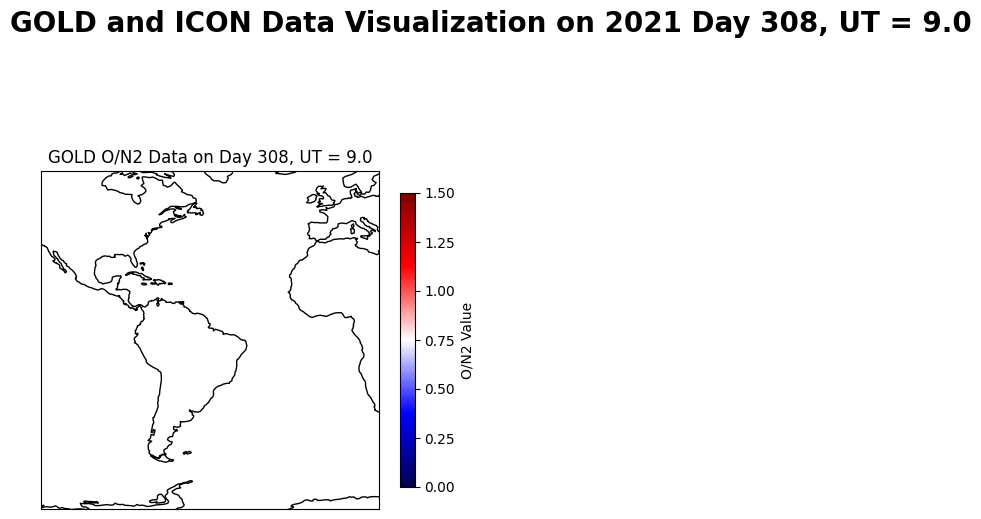

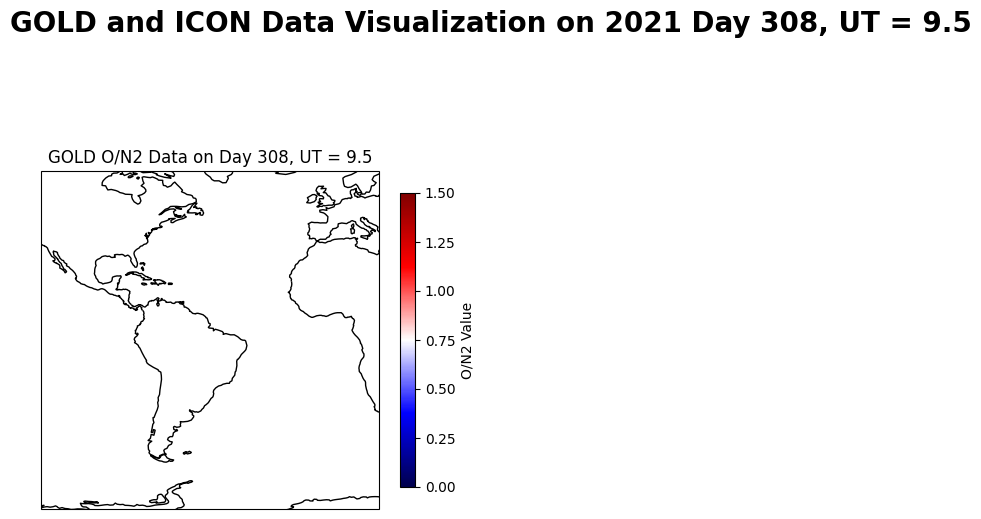

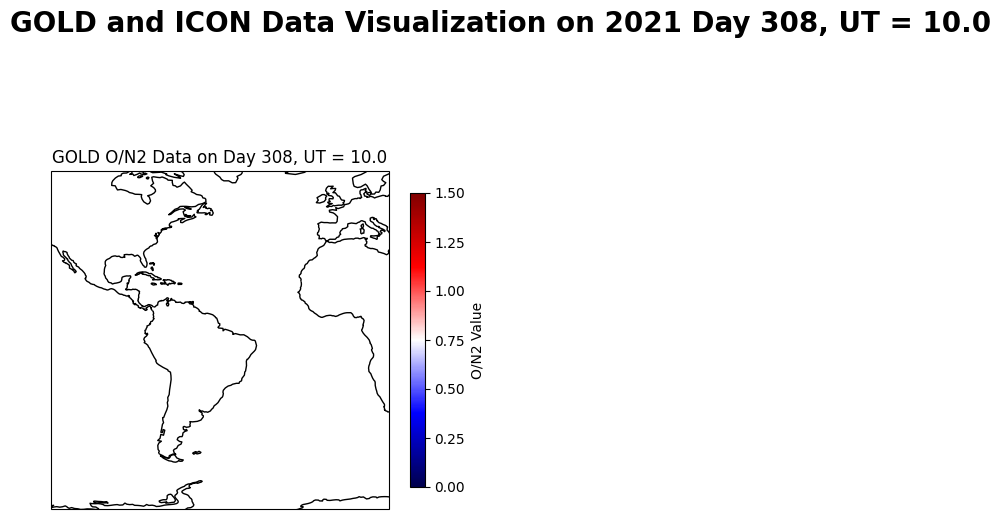

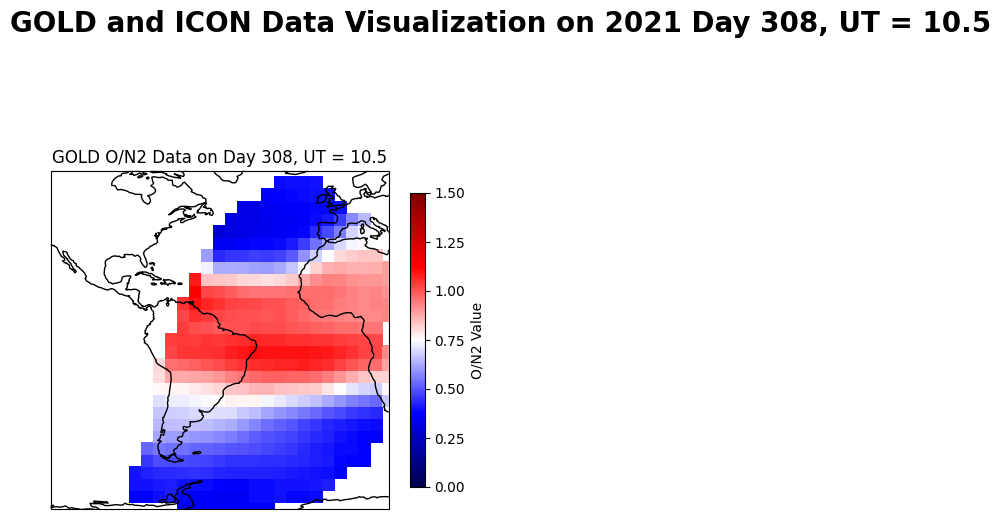

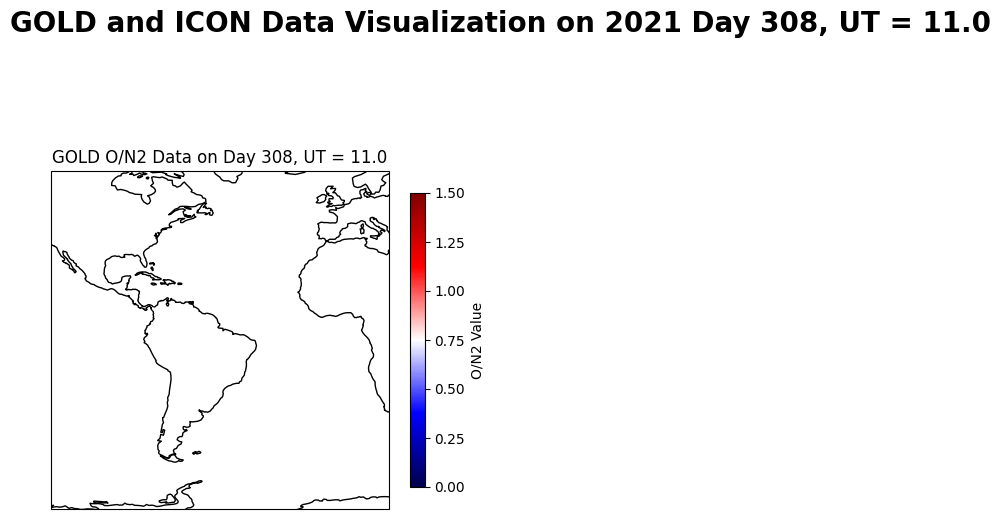

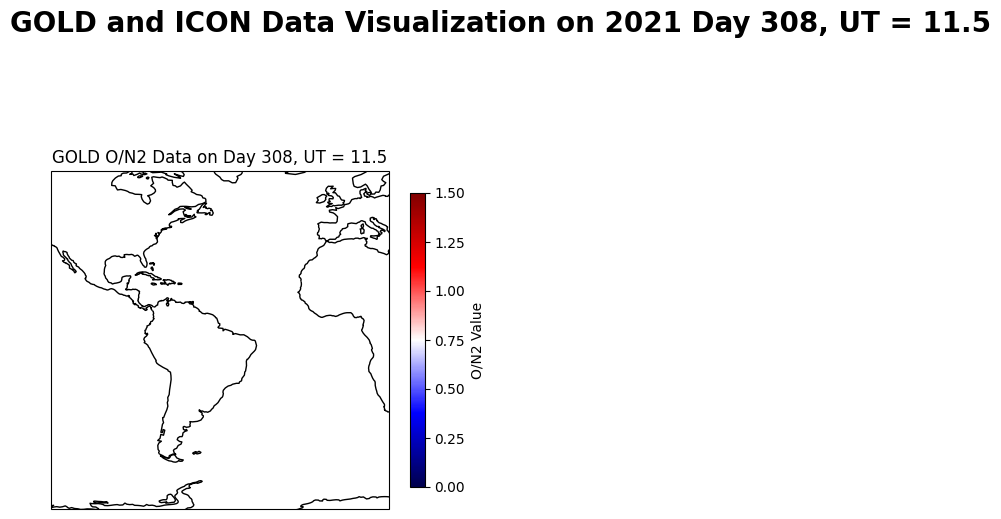

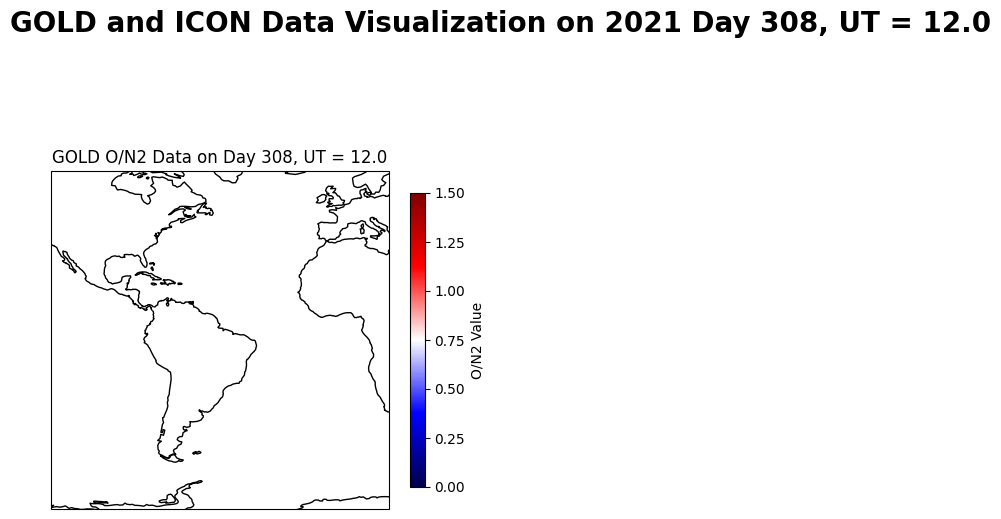

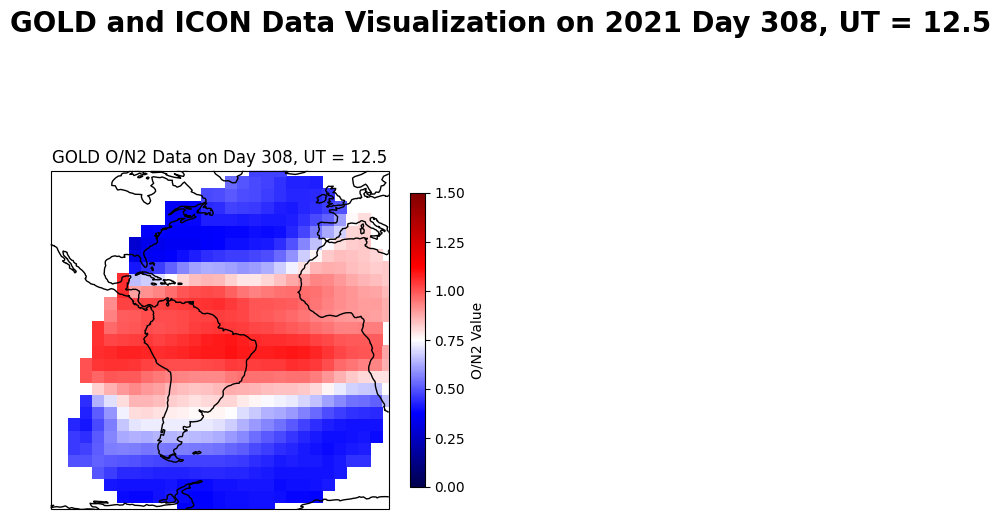

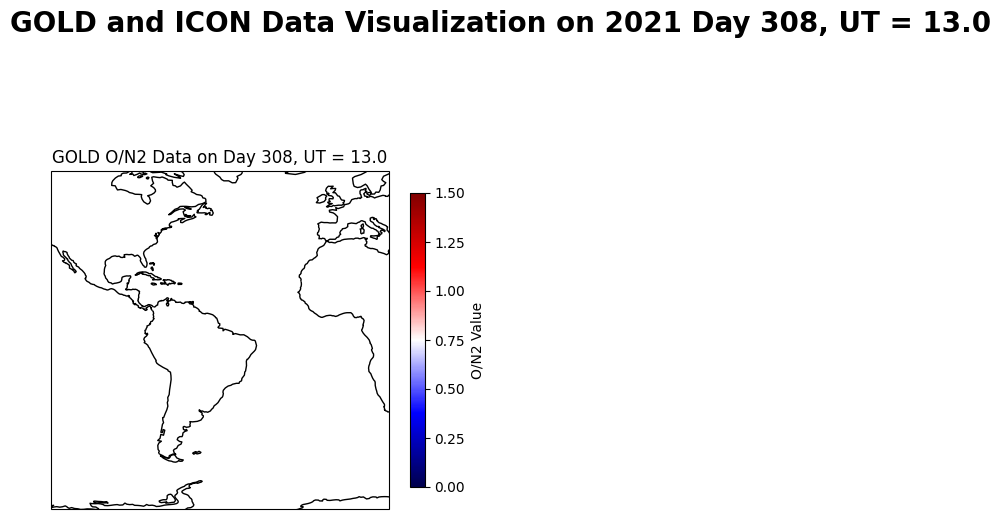

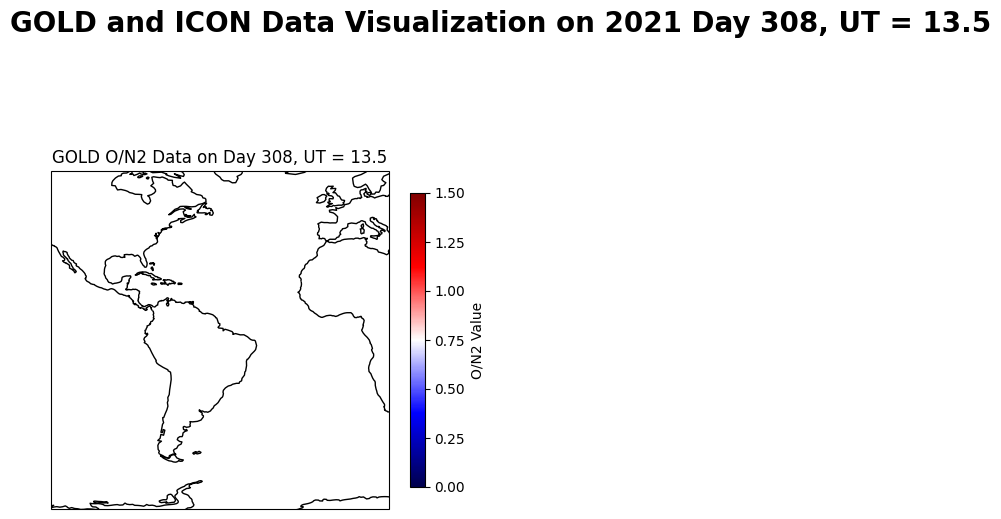

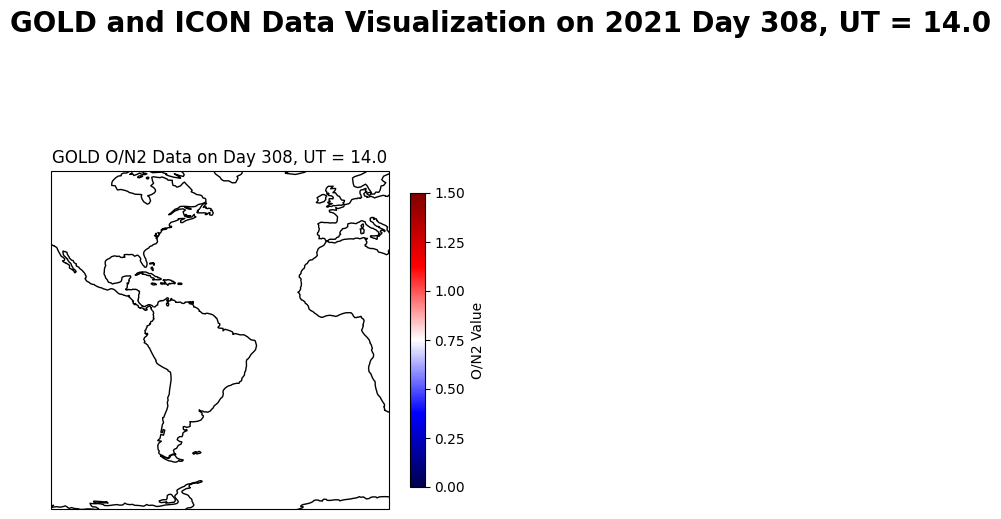

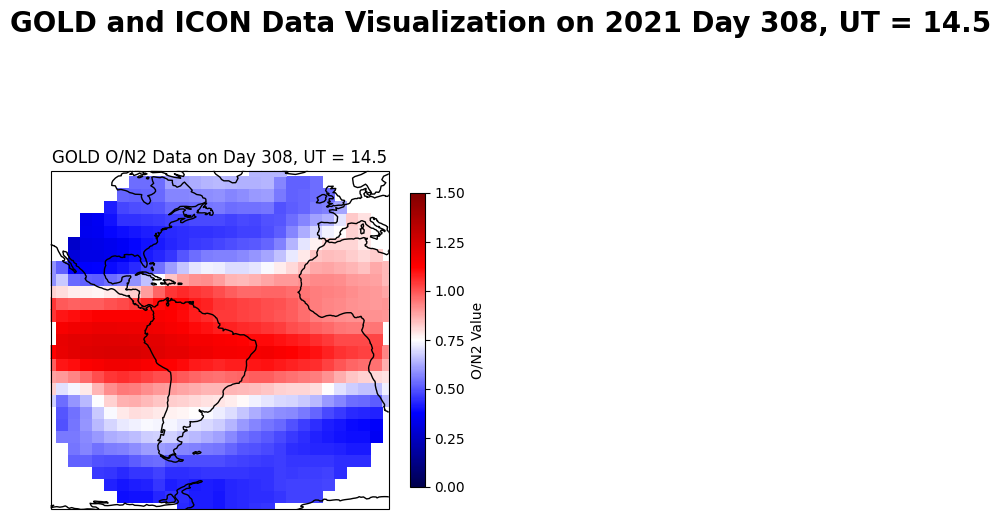

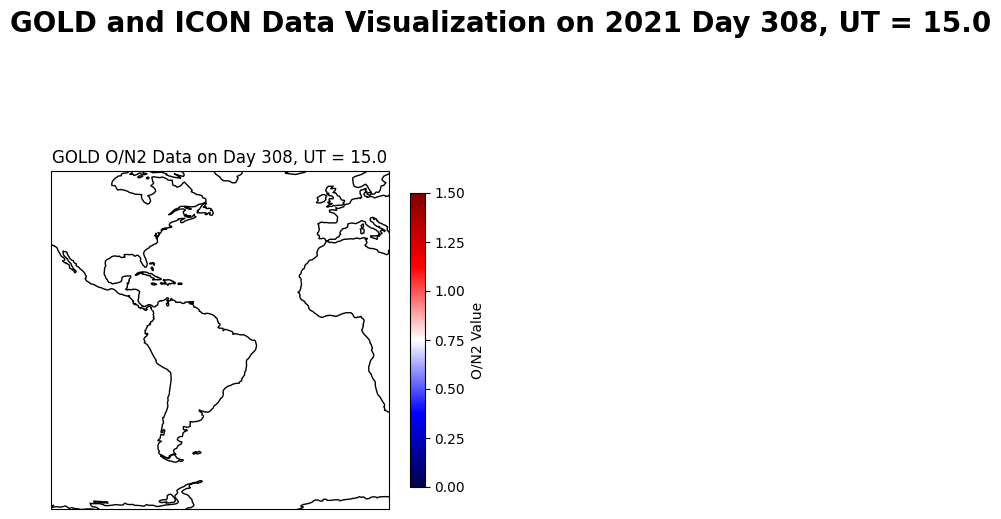

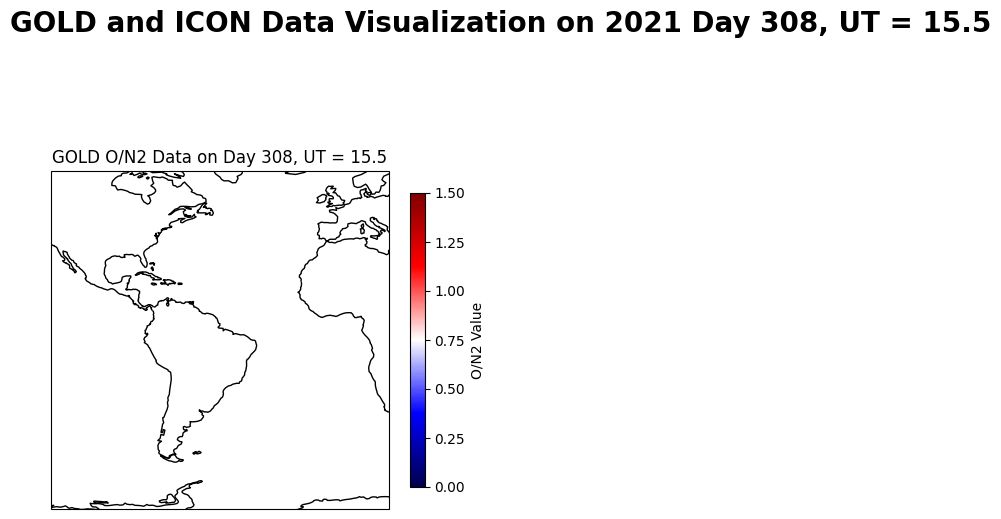

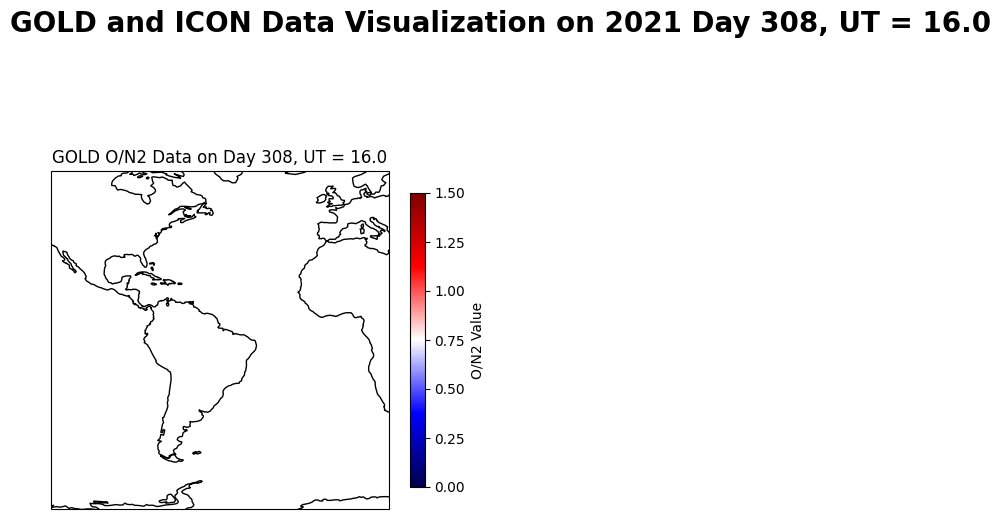

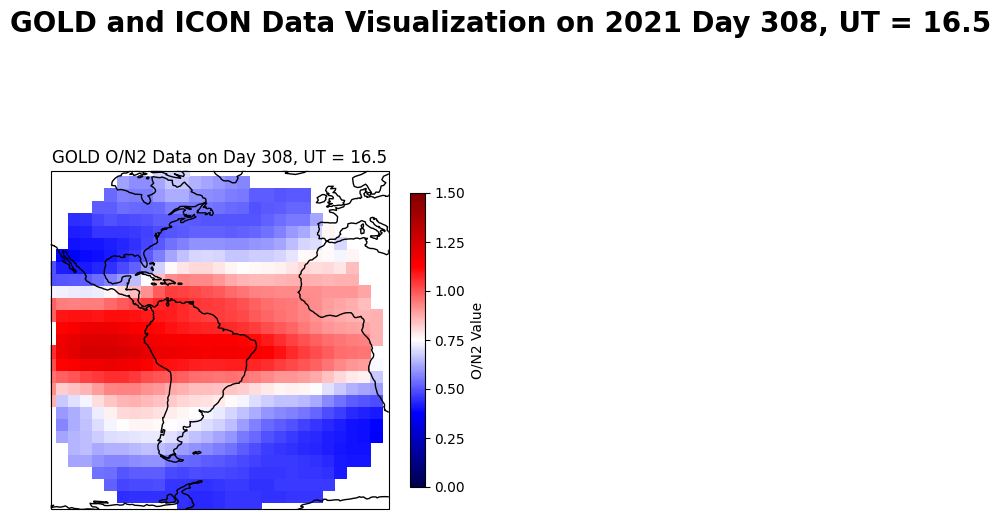

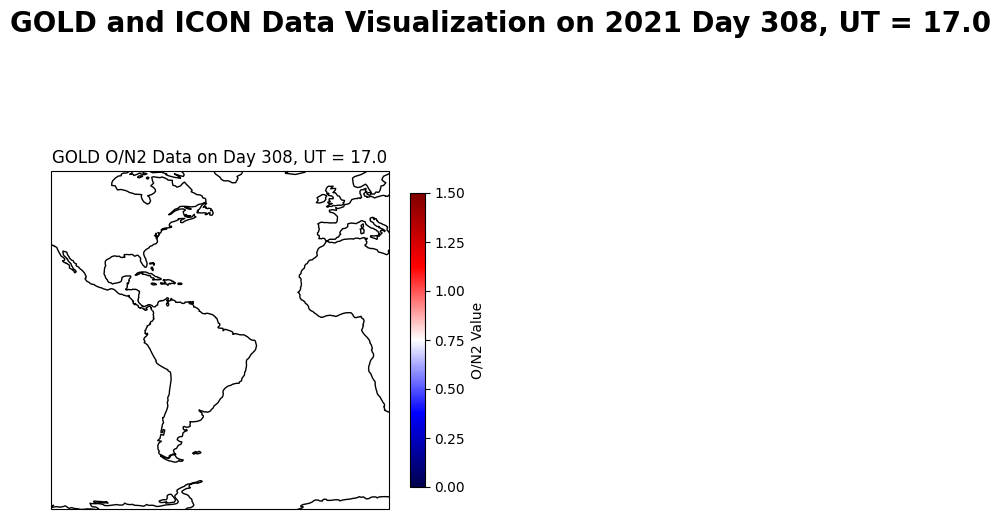

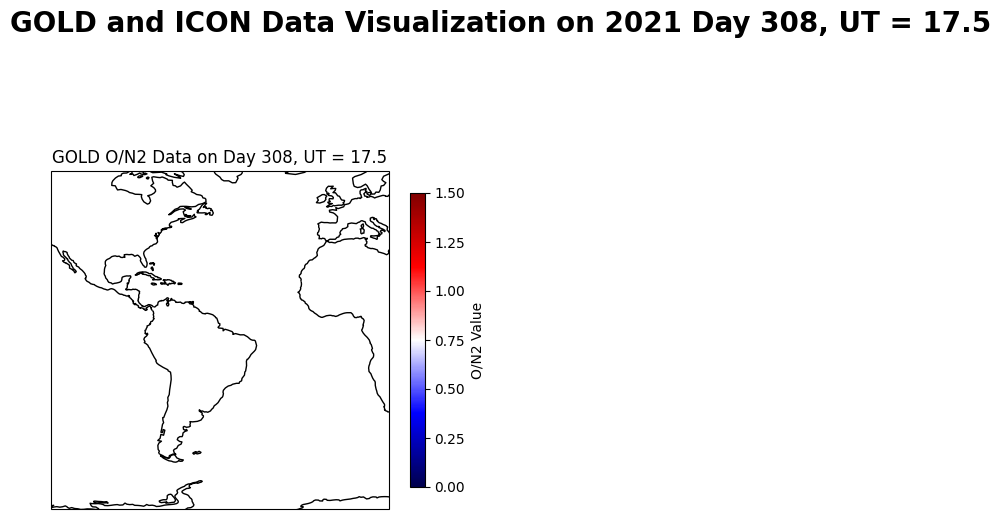

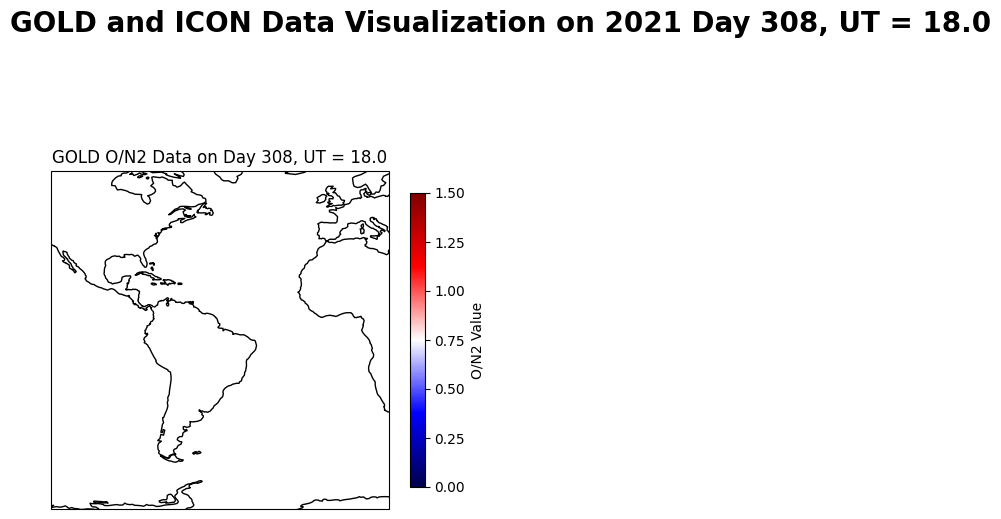

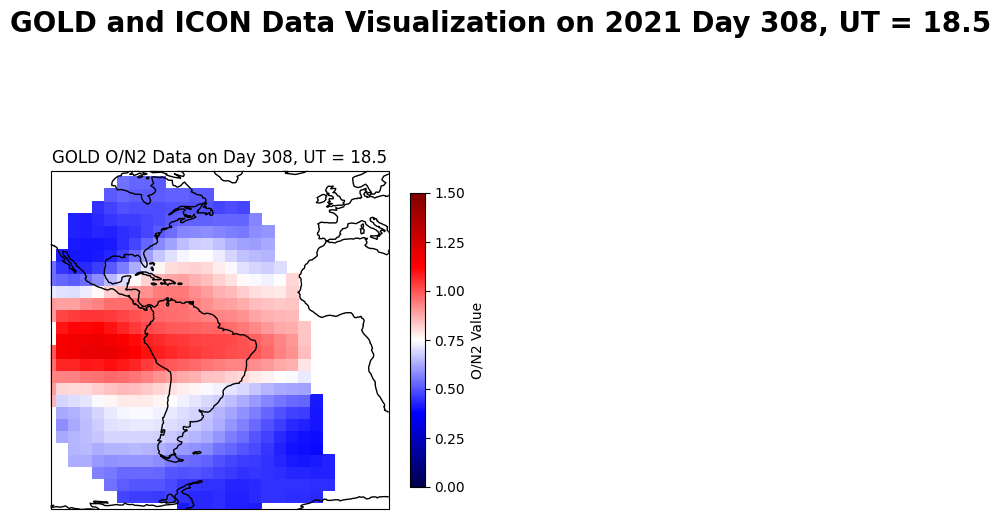

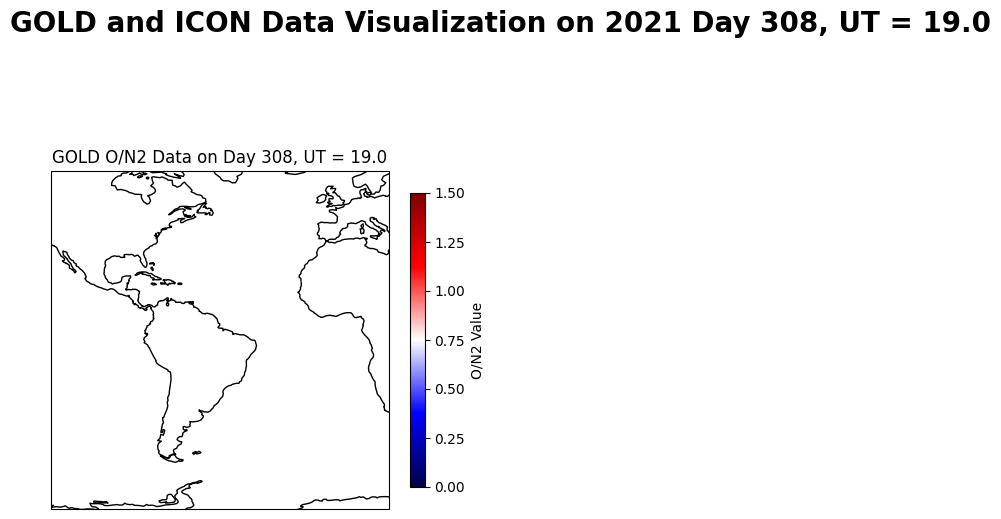

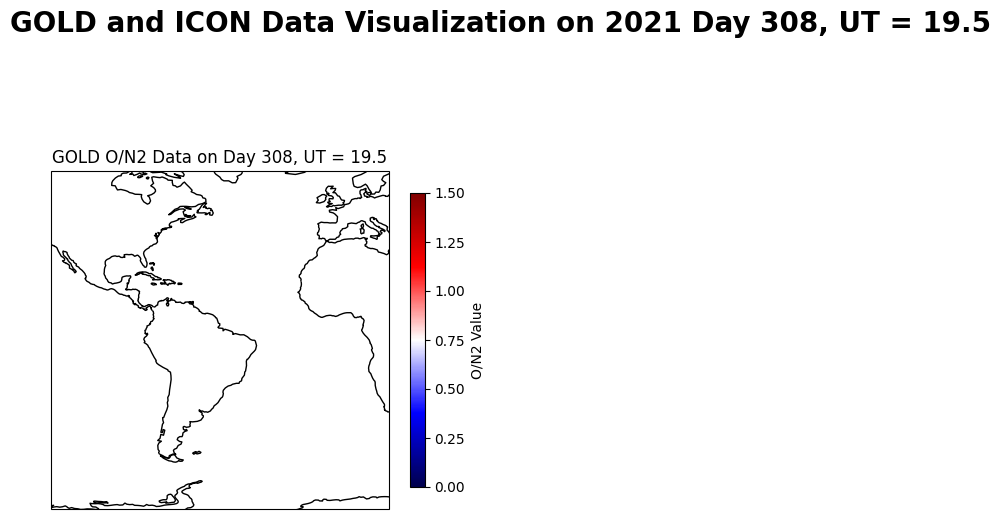

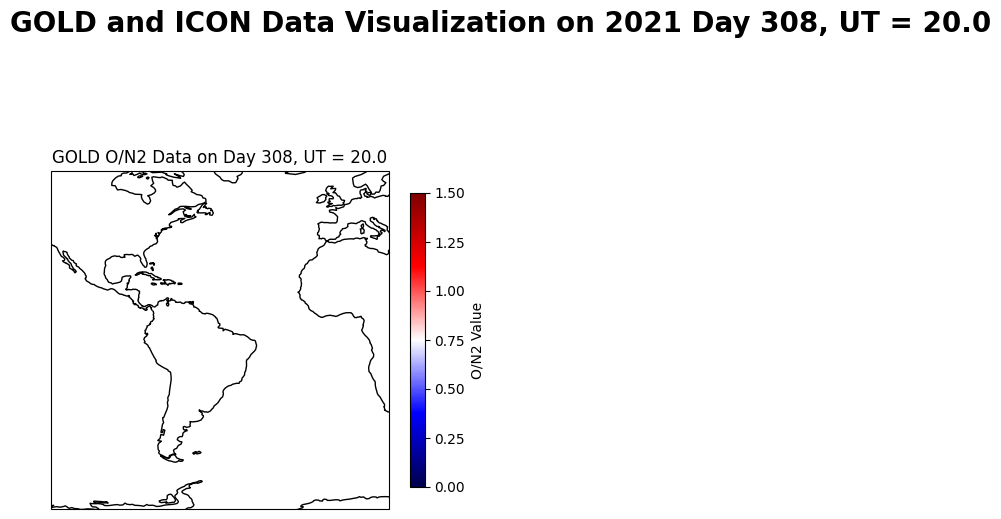

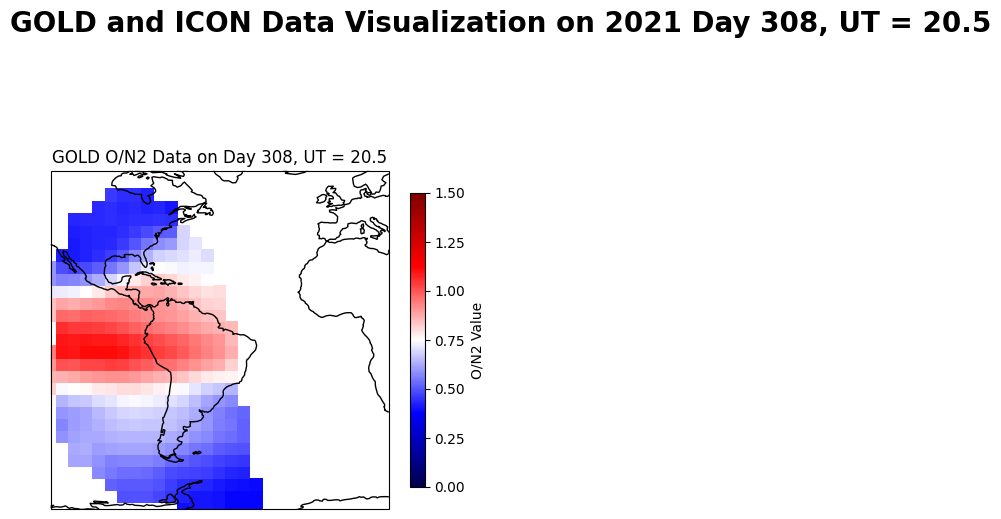

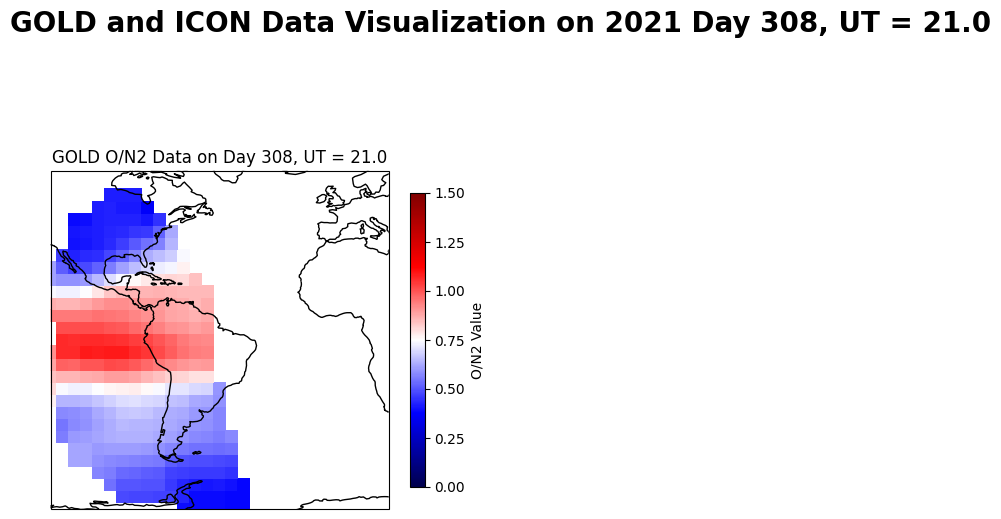

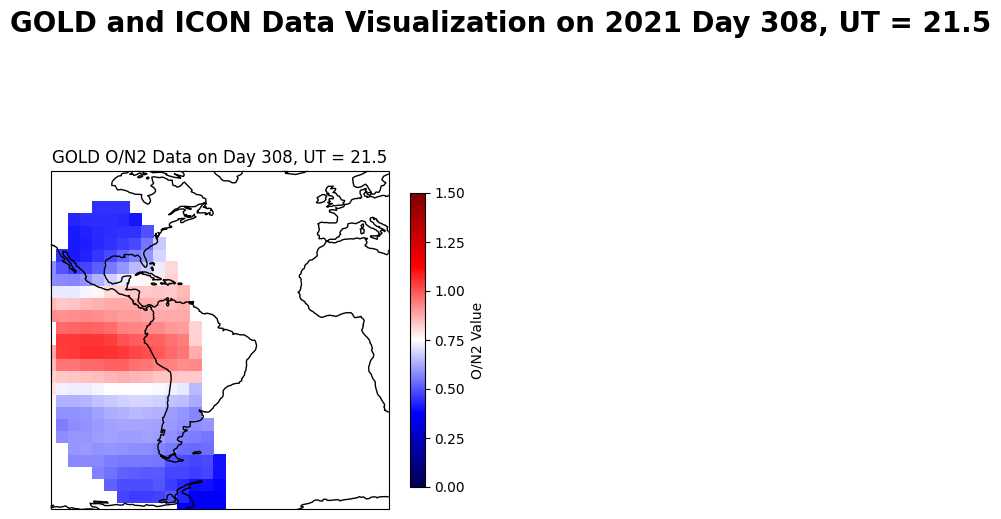

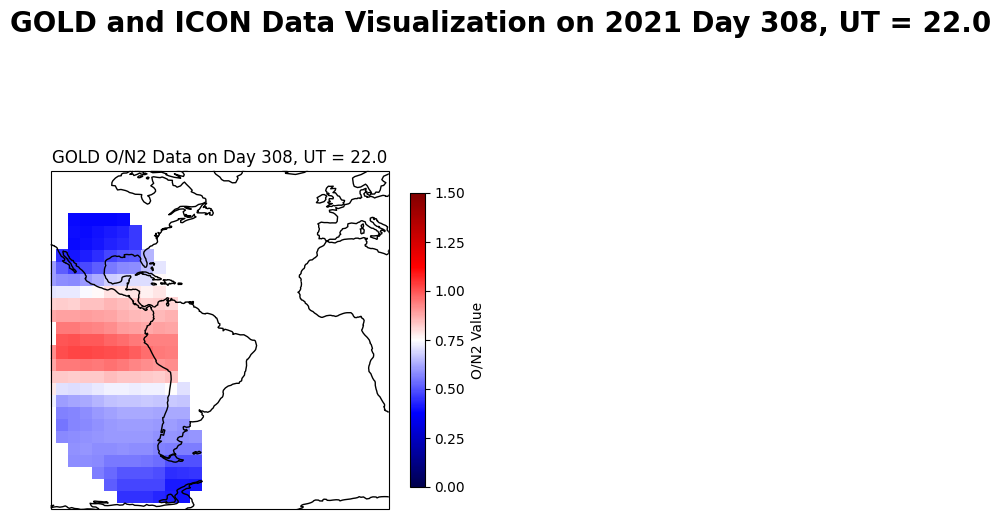

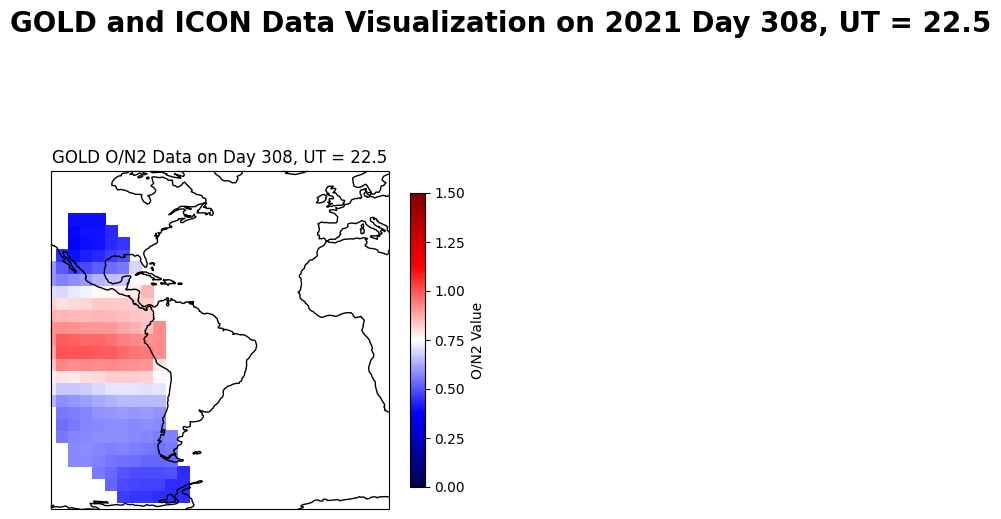

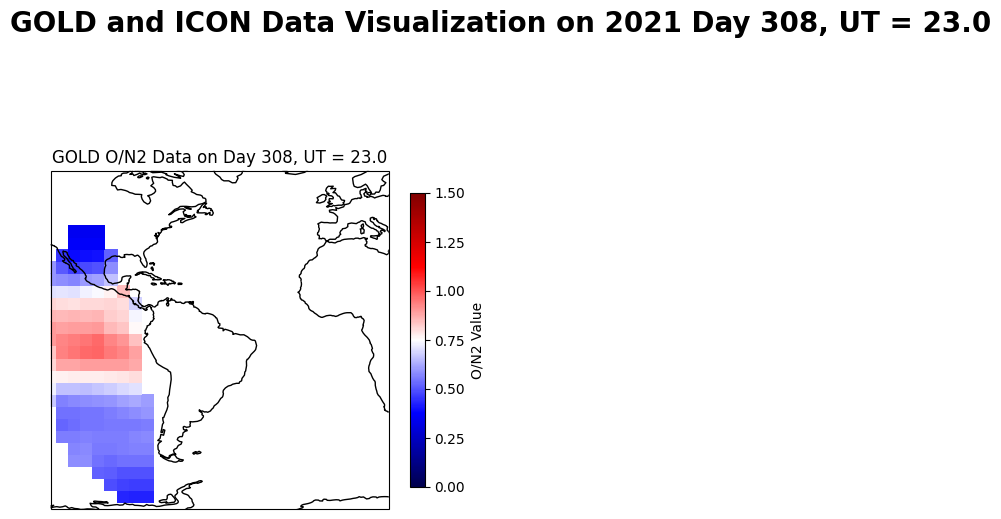

In [ ]:
drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/ColabNotebooks/Data 24 11 26/'
#this is the locaiton of where I save my graphs, please change the path to your own drive path

if not os.path.exists(save_path):
    os.makedirs(save_path)

# ------------------ shortcut ------------------
icon_condition = (doyICON >= 308) & (doyICON < 309)
icon_filtered_indices = np.where(icon_condition)[0]

icon_lons_filtered = lons[icon_filtered_indices]
icon_lats_filtered = lats[icon_filtered_indices]
icon_uwnd_filtered = uwndicon[icon_filtered_indices]
icon_vwnd_filtered = vwndicon[icon_filtered_indices]
icon_uwndmean_filtered = uwndmeanicon[icon_filtered_indices]
icon_vwndmean_filtered = vwndmeanicon[icon_filtered_indices]
icon_uwndresidues_filtered = uwndresiduesicon[icon_filtered_indices]
icon_vwndresidues_filtered = vwndresiduesicon[icon_filtered_indices]

# Loop through valid `ut_gold` times
for ut_value in ut_gold:
    try:
        ut_index = int((ut_value - ut_gold[0]) * 2)
        if ut_index < 0 or ut_index >= on2_gold.shape[1]:
            print(f"Skipping UT index {ut_index} as it is out of bounds.")
            continue
        fig = plt.figure(figsize=(12, 12))
        gs = gridspec.GridSpec(2, 2, height_ratios=[2, 2])
        fig.suptitle(f"GOLD and ICON Data Visualization on 2021 Day 308, UT = {ut_value:.1f}", fontsize=20, weight='bold')

# ------------------ GOLD O/N2 (Graph 1) ------------------
        ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
        ax1.set_xlabel('Longitude')
        ax1.set_ylabel('Latitude')
        ax1.set_title(f'GOLD O/N2 Data on Day 308, UT = {ut_value:.1f}')
        ax1.set_xlim(lon_min_valid, lon_max_valid)
        ax1.set_ylim(lat_min_valid, lat_max_valid)
        ax1.add_feature(cfeature.COASTLINE)

        valid_on2_grid = np.full((lat_len, lon_len), np.nan)
        for i in range(lat_len):
            for j in range(lon_len):
                if i < on2_gold.shape[2] and j < on2_gold.shape[3]:
                    on2 = on2_gold[doy_index, ut_index, i, j].values.item()
                    if on2 != 0 and not np.isnan(on2):
                        valid_on2_grid[i, j] = on2

        mesh1 = ax1.pcolor(
            gold_and_icon['LONGOLD'].values,
            gold_and_icon['LATGOLD'].values,
            valid_on2_grid,
            cmap='seismic',
            shading='auto',
            vmin=0,
            vmax=1.5
        )
        fig.colorbar(mesh1, ax=ax1, label='O/N2 Value', ticks=np.linspace(0, 1.5, 7), shrink=0.7)

        gold_time_fraction = 308 + ut_value / 24
        time_margin = 1 / 48
        condition = (doyICON >= gold_time_fraction - time_margin) & (doyICON <= gold_time_fraction + time_margin)
        filtered_indices = np.where(condition)[0]

        lons_filtered = lons[filtered_indices]
        lats_filtered = lats[filtered_indices]
        uwndicon_filtered = uwndicon[filtered_indices]
        vwndicon_filtered = vwndicon[filtered_indices]
        uwndmeanicon_filtered = uwndmeanicon[filtered_indices]
        vwndmeanicon_filtered = vwndmeanicon[filtered_indices]
        uwndresiduesicon_filtered = uwndresiduesicon[filtered_indices]
        vwndresiduesicon_filtered = vwndresiduesicon[filtered_indices]

        ax1.quiver(
            lons_filtered, lats_filtered,
            uwndicon_filtered, vwndicon_filtered,
            color='black', scale=2500, width=0.005, label='Original Wind'
        )
        ax1.quiver(
            lons_filtered, lats_filtered,
            uwndmeanicon_filtered, vwndmeanicon_filtered,
            color='blue', scale=2500, width=0.005, label='Mean Wind'
        )
        ax1.quiver(
            lons_filtered, lats_filtered,
            uwndresiduesicon_filtered, vwndresiduesicon_filtered,
            color='green', scale=2500, width=0.005, label='Residual Wind'
        )
        ax1.legend(loc='lower left')
        ax1.gridlines(draw_labels=True)

# ------------------ GOLD TDisk (Graph 2) ------------------
        ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
        ax2.set_xlabel('Longitude')
        ax2.set_ylabel('Latitude')
        ax2.set_title(f'GOLD Tdisk Data on Day 308, UT = {ut_value:.1f}')
        ax2.set_xlim(lon_min_valid, lon_max_valid)
        ax2.set_ylim(lat_min_valid, lat_max_valid)
        ax2.add_feature(cfeature.COASTLINE)

        valid_tdisk_grid = np.full((lat_len, lon_len), np.nan)
        for i in range(lat_len):
            for j in range(lon_len):
                if i < tdisk_gold.shape[2] and j < tdisk_gold.shape[3]:
                    tdisk = tdisk_gold[doy_index, ut_index, i, j].values.item()
                    if not np.isnan(tdisk):
                        valid_tdisk_grid[i, j] = tdisk
        mesh2 = ax2.pcolor( gold_and_icon['LONGOLD'].values, gold_and_icon['LATGOLD'].values, valid_tdisk_grid,
                   cmap='coolwarm', shading='auto')
        fig.colorbar(mesh2, ax=ax2, label='Tdisk Value', shrink=0.7)

        ax2.quiver( lons_filtered, lats_filtered, uwndicon_filtered, vwndicon_filtered,
            color='black', scale=2500, width=0.005, label='Original Wind')
        ax2.quiver( lons_filtered, lats_filtered, uwndmeanicon_filtered, vwndmeanicon_filtered,
            color='blue', scale=2500, width=0.005, label='Mean Wind')
        ax2.quiver( lons_filtered, lats_filtered, uwndresiduesicon_filtered, vwndresiduesicon_filtered,
            color='green', scale=2500, width=0.005, label='Residual Wind')
        ax2.legend(loc='lower left')
        ax2.gridlines(draw_labels=True)

# ------------------ ICON Wind Vectors (Graph 3) ------------------
        ax3 = fig.add_subplot(gs[1, :], projection=ccrs.PlateCarree())
        ax3.set_xlabel('Longitude')
        ax3.set_ylabel('Latitude')
        ax3.set_title('ICON Wind Vectors on 2021 Day 308')
        ax3.set_xlim(-180, 180)
        ax3.set_ylim(-20, 50)
        ax3.add_feature(cfeature.COASTLINE)
        ax3.gridlines(draw_labels=True)

        ax3.quiver(icon_lons_filtered, icon_lats_filtered, icon_uwnd_filtered, icon_vwnd_filtered, color='gray', scale=15000, width=0.001, label='Original Wind')
        ax3.quiver(icon_lons_filtered, icon_lats_filtered, icon_uwndmean_filtered, icon_vwndmean_filtered, color='blue', scale=15000, width=0.001, label='Mean Wind')
        ax3.quiver(icon_lons_filtered, icon_lats_filtered, icon_uwndresidues_filtered, icon_vwndresidues_filtered, color='green', scale=15000, width=0.001, label='Residual Wind')
        ax3.legend(loc='upper left')

        # Save figure to Google Drive
        fig_filename = f"GOLD_ICON_2021_Day308_UT{ut_value:.1f}.png"
        fig.savefig(save_path + fig_filename, dpi=300)

# ------------------ Output ------------------
        plt.subplots_adjust(hspace=0.0001, wspace=0.00001, top=1)  # Add space between plots
        plt.tight_layout()
        plt.close(fig)  # Close the figure to free memory

    except Exception as e:
        print(f"Error encountered at UT value {ut_value}: {e}")


##Step 7: Sort all data graphs into video
using the files saved in drive to create a video

In [ ]:
input_dir = '/content/drive/MyDrive/ColabNotebooks/Data 24 11 26/'
output_video_path = '/content/drive/MyDrive/ColabNotebooks/Data 24 11 26/output_video.mp4'

image_files = sorted(
    [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith(('.png', '.jpg'))]
)

if not image_files:
    raise ValueError("No image files found in the specified directory!")

fps = 2 #change this number to make
with imageio.get_writer(output_video_path, fps=fps) as writer:
    for image_file in image_files:
        image = imageio.imread(image_file)
        writer.append_data(image)

print(f"Video saved at {output_video_path}")

##Congrats for finishing!

In [ ]:
print(f"Congrats! Enjoy!")

Congrats! Enjoy!
